In [1]:
# use a image classification model to perform dimension reduction to visualize similarity among images

import numpy as np
import pandas as pd
import os

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset

import matplotlib.pyplot as plt

# prepare loader for test images

device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

normalize = transform.Normalize((0.4124234616756439, 0.3674212694168091, 0.2578217089176178), (0.3268945515155792, 0.29282665252685547, 0.29053378105163574))

transform_original = transform.Compose([
transform.Resize((224, 224)),
transform.ToTensor(), 
normalize,
])

test = ImageFolder(os.path.join('splitted','test'), transform=transform_original)
test_loader = DataLoader(test, batch_size=64, num_workers=4, pin_memory=True, shuffle=True)

x,y = next(iter(test_loader))
x.shape

torch.Size([64, 3, 224, 224])

In [2]:
# load pretrained resnet on imagenet
model1 = torchvision.models.resnet101(weights='IMAGENET1K_V1')
for param in model1.parameters():
    param.requires_grad = False
model1 = torch.nn.Sequential(*list(model1.children())[:-1]+[torch.nn.Flatten()])
model1.eval()
model1.to(device)
model1(x.to(device)).shape #the feature vector of each image is of dimensioin 2048

torch.Size([64, 2048])

In [3]:
# load resnet trained with the same dataset. F1 score is 0.947
model2 = torchvision.models.resnet101(pretrained=False)
model2.fc = nn.Linear(in_features=model2.fc.in_features, out_features=len(test.classes), bias=True)
PATH = './resnet _transfer.pth'
model2.load_state_dict(torch.load(PATH))
for param in model2.parameters():
    param.requires_grad = False
model2 = torch.nn.Sequential(*list(model2.children())[:-1]+[torch.nn.Flatten()])
model2.eval()
model2.to(device)
model2(x.to(device)).shape

torch.Size([64, 2048])

In [4]:
# concat feature vector for all test images
features1_lst,features2_lst,label_lst = [],[],[]
import itertools
from skimage.io import imsave
def norm_out(img):
    mean = torch.FloatTensor([0.4124234616756439, 0.3674212694168091, 0.2578217089176178])
    std = torch.FloatTensor([0.3268945515155792, 0.29282665252685547, 0.29053378105163574])
    img = img*std + mean
    return np.clip(img,0,1)

counter = 0
for x,y in itertools.islice(test_loader, 10):
    features1_lst.append(model1(x.to(device)).cpu().numpy())
    features2_lst.append(model2(x.to(device)).cpu().numpy())
    label_lst.append(y.numpy())

    img = (norm_out(x.permute(0,2,3,1).cpu()).numpy()*255).astype(np.uint8)
    for i in range(img.shape[0]):
        img_path = os.path.join('imgs',str(counter)+'.png')# save test images to the same directory for visualization
        imsave(img_path,img[i])
        counter += 1
    
features1_lst,features2_lst,label_lst = np.vstack(features1_lst),np.vstack(features2_lst),np.hstack(label_lst)

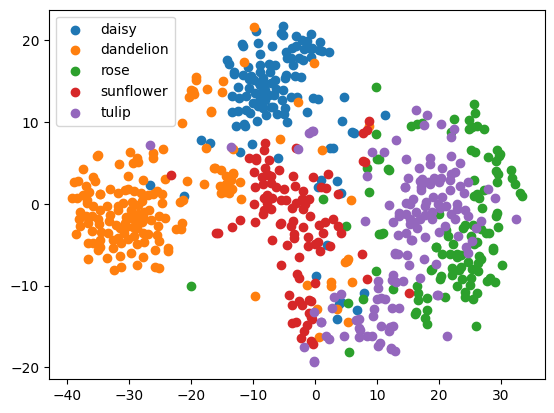

In [5]:
# use TSNE to visualize the feature vector distribution
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features1_lst)
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

fig = plt.figure()
ax = fig.add_subplot(111)
for i,classname in enumerate(test.classes):
    msk = label_lst==i
    ax.scatter(tx[msk],ty[msk],color=plt.cm.tab10(i),label=classname)
ax.legend(loc='best')

In [6]:
# show image when hovering over points in the scatter plot
from bokeh_scatter import create_html
df = pd.DataFrame({'x':tx,'y':ty,'label':label_lst.astype(str)})
df.index = df.index.rename('index')
df = df.reset_index()
df['imgs'] = 'imgs/'+df['index'].astype(int).astype('str')+'.png'
create_html("resnet-tsne1.html",{name:row.values.tolist() for name,row in df.T.iterrows()})

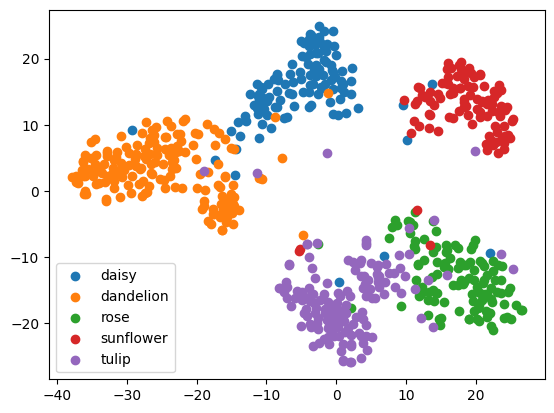

In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(features2_lst)
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]

fig = plt.figure()
ax = fig.add_subplot(111)
for i,classname in enumerate(test.classes):
    msk = label_lst==i
    ax.scatter(tx[msk],ty[msk],color=plt.cm.tab10(i),label=classname)
ax.legend(loc='best')

In [8]:
from bokeh_scatter import create_html
df = pd.DataFrame({'x':tx,'y':ty,'label':label_lst.astype(str)})
df.index = df.index.rename('index')
df = df.reset_index()
df['imgs'] = 'imgs/'+df['index'].astype(int).astype('str')+'.png'
create_html("resnet-tsne2.html",{name:row.values.tolist() for name,row in df.T.iterrows()})